In [1]:
#HTML 페이지 크롤링  https://finance.naver.com/sise/sise_index.nhn?code=KPI200에서 일별시세 크롤링
index_cd = 'KPI200'
page_n = 1
naver_index = 'https://finance.naver.com/sise/sise_index_day.nhn?code=' + index_cd + '&page=' + str(page_n) #일별시세-프레임소스보기

In [2]:
from urllib.request import urlopen
source = urlopen(naver_index).read()
#source #너무 복잡함 -> BeauifulSoup와 prettify()를 이용 보기좋게 정렬

In [3]:
import bs4
source = bs4.BeautifulSoup(source, 'lxml') #BeautifulSoup()함수의 객체는 문자열임을 알 수 있음

In [4]:
#print(source.prettify())

In [5]:
td = source.find_all('td') #날짜와 종가는 td클래스에 들어가 있음
len(td)

54

In [6]:
#날짜의 X-path 주소 : /html/body/div/table[1]/tbody/tr[3]/td[1]
source.find_all('table')[0].find_all('tr')[2].find_all('td')[0] #숫자를 하나씩 뺴주기

<td class="date">2020.07.23</td>

In [7]:
d = source.find_all('td', class_='date')[0].text # <td class="date">처럼 클래스 이름을 이용해서도 태그를 뽑아낼 수 있음
d

'2020.07.23'

In [8]:
import datetime as dt
yyyy = int(d.split('.')[0]) # d.spilt(',') 하면 [2020,07,21]의 리스트로 값이 반환(이때 반환되는 값은 문자열이므로 정수로 변환)
mm = int(d.split('.')[1])
dd = int(d.split('.')[2])
this_date = dt.date(yyyy,mm,dd) #date()함수를 이용, 날짜 생성
this_date

datetime.date(2020, 7, 23)

In [9]:
#읽어온 날짜 정보를 date 형식으로 바꿔줄 일이 계속 생기므로 이 기능을 함수로 정의
def date_format(d):
    d = str(d).replace('-', '.') # 날짜가 -로 구분되어있을 경우 .로 바꿈
    yyyy=int(d.split('.')[0])
    mm=int(d.split('.')[1])
    dd=int(d.split('.')[2])
    
    this_date = dt.date(yyyy,mm,dd)
    return this_date


In [10]:
#이번에는 지수를 가져오면
#지수의 X-path: /html/body/div/table[1]/tbody/tr[3]/td[2]
this_close=source.find_all('table')[0].find_all('tr')[2].find_all('td')[1].text
this_close=this_close.replace(',','') #쉼표가 있으면 쉼표빼주기(문자열숫자->정수숫자로 바꿀때 필수)
this_close=float(this_close)
this_close

292.37

In [11]:
#클래스이름을 이용하면 역시 간단하게 나타낼 수 있음
this_close=source.find_all('table')[0].find_all('tr')[2].find_all('td')[1]
this_close

<td class="number_1">292.37</td>

In [12]:
p = source.find_all('td', class_='number_1')[0].text
p

'292.37'

In [13]:
dates=source.find_all('td',class_='date')
prices=source.find_all('td', class_='number_1')
#페이지에 있는 모든 날짜와 가격 불러옴, 이때 가격은 체결가, 등락률, 거래량, 거래대금이 포함되므로 
#우리가 필요한 체결가(종가) 있는 0,4,8 단위로 추출
for n in range(len(dates)): #dates개수만큼 반복
    this_date = dates[n].text
    this_date = date_format(this_date)
    
    this_close=prices[n*4].text
    this_close=this_close.replace(',', '') 
    this_close=float(this_close)
    this_close
    
    print(this_date, this_close)

2020-07-23 292.37
2020-07-22 294.04
2020-07-21 295.16
2020-07-20 290.81
2020-07-17 291.57
2020-07-16 289.25


In [14]:
#현재 페이지에서 날짜와 종가추출을 완료 했으므로 페이지별로 날짜/종가지수 추출
#페이지 네비게이션에서 <맨뒤> 탭 검사
paging = source.find('td', class_='pgRR').find('a')['href']
paging

'/sise/sise_index_day.nhn?code=KPI200&page=600'

In [15]:
paging = paging.split('&')[1] # 위 링크 & 뒤 부분만 추출
paging = paging.split('=')[1] # page=600 에서 = 뒤 부분 추출
#마지막 페이지를 뽑는 과정을 정리하면
last_page = source.find('td',class_='pgRR').find('a')['href']
last_page = last_page.split('&')[1]
last_page = last_page.split('=')[1]
last_page=int(last_page)

In [16]:
#데이터 추출 함수 만들기
def historical_index_naver(index_cd, page_n=1, last_page=0):
    naver_index = 'https://finance.naver.com/sise/sise_index_day.nhn?code=' + index_cd + '&page=' + str(page_n) #일별시세-프레임소스보기
    source = urlopen(naver_index).read()
    source = bs4.BeautifulSoup(source, 'lxml') 
    
    dates=source.find_all('td',class_='date') #<td class ="date">태그에서 날짜수집
    prices=source.find_all('td', class_='number_1') #<td class = "number_1">태그에서 지수수집
    
    for n in range(len(dates)): #dates개수만큼 반복
        if dates[n].text.split('.')[0].isdigit():
            #날짜처리
            this_date = dates[n].text
            this_date = date_format(this_date)
            
            #종가처리
            this_close=prices[n*4].text
            this_close=this_close.replace(',', '') 
            this_close=float(this_close)
            this_close
    
            #딕셔너리에 저장
            historical_prices[this_date] = this_close
    
    #페이지 네비게이션
    if last_page ==0:
        last_page = source.find('td',class_='pgRR').find('a')['href']
        #마지막페이지 주소 추출
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page=int(last_page)
    
    #다음페이지 호출
    if page_n < last_page:
        page_n = page_n +1
        historical_index_naver(index_cd, page_n, last_page)
    
    return historical_prices
         

In [17]:
historical_prices = dict()

In [18]:
#historical_index_naver('KPI200')

In [19]:
#len(historical_prices)

In [20]:
#날짜 탐색기능이 추가된 전체함수
def historical_index_naver_date(index_cd, start_date='', end_date='', page_n=1, last_page=0):
    if start_date: #start_date가 있으면
        start_date=date_format(start_date)
    else: #없으면
        start_date = dt.date.today() #오늘날짜 지정
    if end_date : #end_date가 있으면
        end_date=date_format(end_date)
    else:
            end_date=dt.date.today()
    
    naver_index = 'https://finance.naver.com/sise/sise_index_day.nhn?code=' + index_cd + '&page=' + str(page_n) #일별시세-프레임소스보기
    source = urlopen(naver_index).read()
    source = bs4.BeautifulSoup(source, 'lxml') 
    
    dates=source.find_all('td',class_='date') #<td class ="date">태그에서 날짜수집
    prices=source.find_all('td', class_='number_1') #<td class = "number_1">태그에서 지수수집
    
    for n in range(len(dates)): #dates개수만큼 반복
        if dates[n].text.split('.')[0].isdigit():
            #날짜처리
            this_date = dates[n].text
            this_date = date_format(this_date)
            
            if this_date <= end_date and this_date >= start_date:
                #종가처리
                this_close=prices[n*4].text
                this_close=this_close.replace(',', '') 
                this_close=float(this_close)
                this_close
    
                #딕셔너리에 저장
                historical_prices_date[this_date] = this_close
            
            elif this_date < start_date:
                return historical_prices_date
    
    #페이지 네비게이션
    if last_page ==0:
        last_page = source.find('td',class_='pgRR').find('a')['href']
        #마지막페이지 주소 추출
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page=int(last_page)
    
    #다음페이지 호출
    if page_n < last_page:
        page_n = page_n +1
        historical_index_naver_date(index_cd, start_date, end_date, page_n, last_page)
    
    return historical_prices_date

In [21]:
historical_prices_date=dict()
#historical_prices_date=historical_index_naver_date('KPI200', '2020.6.20', '2020.7.20')

In [22]:
historical_prices_date

{}

In [23]:
#해외에서 지수 수집하기(JSON 파일 크롤링)
import pandas as pd
from urllib.request import urlopen
import json # 해외지수는 JSON 형태로 표출

#해외증시 URL(검사>Network에서 Link Address copy): https://finance.naver.com/world/worldDayListJson.nhn?symbol=NII@NI225&fdtc=0&page=4
symbol = 'NII@NI225'
page=1

In [24]:
url = 'https://finance.naver.com/world/worldDayListJson.nhn?symbol=' + symbol + '&fdtc=0&page=' + str(page)
raw = urlopen(url)
data = json.load(raw)

In [25]:
data[0] #'xymd' 에 날짜, 'clos'에 종가 데이터가 있는 것을 확인

{'symb': 'NII@NI225',
 'xymd': '20200722',
 'open': 22791.75,
 'high': 22855.31,
 'low': 22732.92,
 'clos': 22751.61,
 'diff': -132.61,
 'rate': -0.58,
 'gvol': 65364200}

In [26]:
type(data)

list

In [27]:
data[:2]

[{'symb': 'NII@NI225',
  'xymd': '20200722',
  'open': 22791.75,
  'high': 22855.31,
  'low': 22732.92,
  'clos': 22751.61,
  'diff': -132.61,
  'rate': -0.58,
  'gvol': 65364200},
 {'symb': 'NII@NI225',
  'xymd': '20200721',
  'open': 22789.38,
  'high': 22925.58,
  'low': 22780.22,
  'clos': 22884.22,
  'diff': 166.74,
  'rate': 0.73,
  'gvol': 68561000}]

In [28]:
data[0]['xymd']

'20200722'

In [29]:
data[0]['clos']

22751.61

In [30]:
#한페이지에 있는 열흘치 데이터 중 날짜와 종가 추출
d = dict()
for n in range(len(data)):
    date=pd.to_datetime(data[n]['xymd']).date() #pd.to_datetime() 함수는 가져온 데이터를 날짜형태로 바꿔줌
    price=float(data[n]['clos'])
    d[date]=price
    
print(d)

{datetime.date(2020, 7, 22): 22751.61, datetime.date(2020, 7, 21): 22884.22, datetime.date(2020, 7, 20): 22717.48, datetime.date(2020, 7, 17): 22696.42, datetime.date(2020, 7, 16): 22770.36, datetime.date(2020, 7, 15): 22945.5, datetime.date(2020, 7, 14): 22587.01, datetime.date(2020, 7, 13): 22784.74, datetime.date(2020, 7, 10): 22290.81, datetime.date(2020, 7, 9): 22529.29}


In [31]:
#지금까지 한 내용을 함수로 만들면
def read_json(d,symbol,page=1):
    url = 'https://finance.naver.com/world/worldDayListJson.nhn?symbol=' + symbol + '&fdtc=0&page=' + str(page)
    raw = urlopen(url)
    data = json.load(raw)
    
    for n in range(len(data)):
        date=pd.to_datetime(data[n]['xymd']).date() #pd.to_datetime() 함수는 가져온 데이터를 날짜형태로 바꿔줌
        price=float(data[n]['clos'])
        d[date]=price
    
    if len(data)==10:
        page+=1
        read_json(d,symbol,page)
    
    return (d)

In [32]:
historical_index=pd.Series() #뜨는 내용은 오류는 아니고 향후 라이브러리 업데이트를 하면서 해당기능을 삭제할 예정이라는 뜻

C:\Users\1\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [33]:
historical_index = read_json(historical_index, symbol, page)

In [34]:
historical_index.head(30)

2020-07-22    22751.61
2020-07-21    22884.22
2020-07-20    22717.48
2020-07-17    22696.42
2020-07-16    22770.36
2020-07-15    22945.50
2020-07-14    22587.01
2020-07-13    22784.74
2020-07-10    22290.81
2020-07-09    22529.29
2020-07-08    22438.65
2020-07-07    22614.69
2020-07-06    22714.44
2020-07-03    22306.48
2020-07-02    22145.96
2020-07-01    22121.73
2020-06-30    22288.14
2020-06-29    21995.04
2020-06-26    22512.08
2020-06-25    22259.79
2020-06-24    22534.32
2020-06-23    22549.05
2020-06-22    22437.27
2020-06-19    22478.79
2020-06-18    22355.46
2020-06-17    22455.76
2020-06-16    22582.21
2020-06-15    21530.95
2020-06-12    22305.48
2020-06-11    22472.91
dtype: float64

In [35]:
#여러 종목을 한꺼번에 수집하면
indices = {
    'SPI@SPX' : 'S&P500',
    'NAS@NDX' : 'Nasdaq 100'
}


In [36]:
#historical_indices = dict()
#for key, value in indices.items():
#    print(key, value)
#    s = dict()
#    s = read_json(s,key,1)
#    historical_indices[value] = s
#prices_df = pd.DataFrame(historical_indices)

In [37]:
#prices_df.head(50) #NaN이라고 뜨는 것은 아마 시차로 인한 개장전 or 휴장 #.head(), .tail()은 앞에서/뒤에서 ~번째 보여달라는 것

In [38]:
# 날짜를 지정해주는 부분을 구현하려면
def date_format(d=''):
    if d!='':
        this_date = pd.to_datetime(d).date()
    else:
        this_date = pd.Timestamp.today().date() #오늘날짜 지정
    return (this_date)

In [39]:
#날짜 처리 부분까지 추가한 해외지수를 크롤링하는 전체 함수를 만들면
def index_global(d, symbol, start_date='', end_date='', page=1):
    
    end_date = date_format(end_date)
    if start_date=='':
        start_date = end_date - pd.DateOffset(months=1) #시작 날짜가 시정되지 않으면 끝 날짜보다 1달 앞으로 지정
    start_date=date_format(start_date)
    
    url = 'https://finance.naver.com/world/worldDayListJson.nhn?symbol=' + symbol + '&fdtc=0&page=' + str(page)
    raw = urlopen(url)
    data = json.load(raw)
    
    if len(data) > 0:
        for n in range(len(data)):
            date = pd.to_datetime(data[n]['xymd']).date()
            
            if date<= end_date and date>= start_date:
                price = float(data[n]['clos'])
                d[date] = price
            elif date <start_date:
                return (d)
        if len(data) == 10:
            page += 1
            index_global(d, symbol, start_date, end_date, page)
    
    return (d)

In [40]:
#historical_indices = dict()
#start_date = '2020.05.20'
#end_date = '2020.07.20'
#for key , value in indices.items():
#    s = dict()
#    s = index_global(s, key, start_date)
#    historical_indices[value] = s
#prices_df.sort_index(inplace=True) #시계열 데이터를 정렬해주어야 함(책에 없는내용)
#prices_df = pd.DataFrame(historical_indices)

NameError: name 'prices_df' is not defined

In [ ]:
#prices_df

In [41]:
#데이터프레임으로 여러 딕셔너리를 테이블 하나로 합치기
historical_prices_date = dict()
kospi200 = historical_index_naver_date('KPI200', '2019.7.22', '2020.7.22')

In [42]:
historical_prices = dict()
sp500 = index_global(historical_prices, 'SPI@SPX', '2019.7.22', '2020.7.22')

In [43]:
#두 데이터는 서로 다른 딕셔너리에 담겨져 있음 -> 딕셔너리를 합쳐서 엑셀처럼 만들어주는 pandas기능 이용
tmp = {'S&P500': sp500, 'KOSPI200' : kospi200}

In [44]:
import pandas as pd
df = pd.DataFrame(tmp) #DataFrame(딕셔너리) -> 엑셀처럼 값을 보여줌
df.sort_index(inplace=True)#시계열데이터 정렬
df.head(30)

,S&P500,KOSPI200
2019-07-22,2985.03,274.55
2019-07-23,3005.47,275.92
2019-07-24,3019.56,273.22
2019-07-25,3003.67,273.04
2019-07-26,3025.86,272.25
2019-07-29,3020.97,267.75
2019-07-30,3013.18,268.95
2019-07-31,2980.38,266.34
2019-08-01,2953.56,265.73
2019-08-02,2932.05,262.99


In [45]:
#데이터가 없을 경우(NaN) -> 앞뒤 가격을 이용해서 데이터를 '보간'
df = df.fillna(method = 'ffill') #ffill은 forward fill 앞의 날짜로 채우는 것
if df.isnull().values.any():
    df=df.fillna(method='bfill') #bfill은 backward fill 뒤의 날짜로 채우는 것
df #이로써 금융빅데이터와 금융머신러닝의 시작이자 갖아 손이 많이가고 번거로운 과정인 데이터 스크레이핑 성공

,S&P500,KOSPI200
2019-07-22,2985.03,274.55
2019-07-23,3005.47,275.92
2019-07-24,3019.56,273.22
2019-07-25,3003.67,273.04
2019-07-26,3025.86,272.25
...,...,...
2020-07-16,3215.57,289.25
2020-07-17,3224.73,291.57
2020-07-20,3251.84,290.81
2020-07-21,3257.30,295.16


No handles with labels found to put in legend.


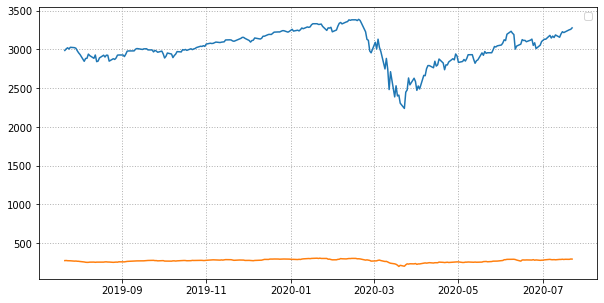

In [46]:
#맷플롯립을 이용해 그래프 그리기
import matplotlib.pyplot as plt
%matplotlib inline 
#이 명령이 없으면 만들어진 그래프를 별도의 화면으로 확인해야 함 -> 노트북 워크스페이스상의 결과화면에 그래프가 나오도록 저장
#우리가 수집한 kospi200과 S&P500 자료를 이용해 그래프를 그리면
plt.figure(figsize=(10,5)) #크기조절
plt.plot(df['S&P500']) #데이터선택
plt.plot(df['KOSPI200']) 
plt.legend(loc=0) #범례 위치 지정
plt.grid(True, color='0.7', linestyle =':', linewidth=1) #그리드설정

In [47]:
#비교를 위해 지수화 작업/ DataFrame에서는 리스트와 유사하게 DataFrame.iloc[] 혹은 DaraFrmae.loc['날짜']를 통해 데이터 지정가능
#loc는 location을 iloc는 indexlocation을 줄인 말
df.iloc[0]

S&P500      2985.03
KOSPI200     274.55
Name: 2019-07-22, dtype: float64

In [48]:
df.loc[dt.date(2019,7,22)]

S&P500      2985.03
KOSPI200     274.55
Name: 2019-07-22, dtype: float64

No handles with labels found to put in legend.


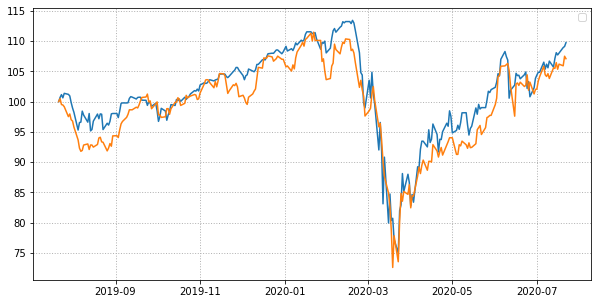

In [49]:
#지수화한 그래프를 다시 그리면
plt.figure(figsize=(10,5))
plt.plot(df['S&P500']/df['S&P500'].loc[dt.date(2019, 7, 22)]*100)
plt.plot(df['KOSPI200']/df['KOSPI200'].loc[dt.date(2019, 7, 22)]*100)
plt.legend(loc=0)
plt.grid(True, color = '0.7',linestyle = ':', linewidth=1)

In [ ]:
#특정 기간의 데이터를 보려면
#import datetime as dt
#df_ratio_now = df.loc[dt.date(2020,1,1):] / df.loc[dt.date(2020,1,2)] *100
#df_ratio_now.head(3)

Text(0, 0.5, 'KOSPI200')

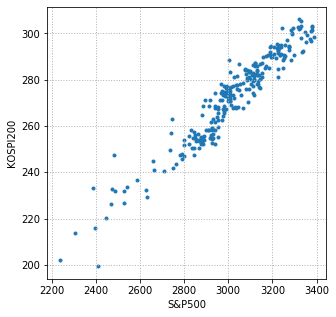

In [54]:
#회귀분석
#산포도 먼저 그려보기
plt.figure(figsize=(5,5))
plt.scatter(df['S&P500'], df['KOSPI200'], marker='.')
plt.grid(True, color='0.7', linestyle =':', linewidth=1)
plt.xlabel('S&P500')
plt.ylabel('KOSPI200')

In [55]:
import numpy as np 
from sklearn.linear_model import LinearRegression #선형 회귀분석을 위한 모델들
x = df['S&P500']
y = df['KOSPI200']

#1개 칼럼 np.array로 변환
independent_var = np.array(x).reshape(-1,1)
dependent_var = np.array(y).reshape(-1,1)

#Linear Regression
regr = LinearRegression()
regr.fit(independent_var, dependent_var)

result = {'Slope': regr.coef_[0,0], 'Intercept':regr.intercept_[0], 'R2':regr.score(independent_var, dependent_var)}
result

{'Slope': 0.08853424260862111,
 'Intercept': 5.1123971684777985,
 'R2': 0.9182937632698022}

Text(0, 0.5, 'KOSPI200')

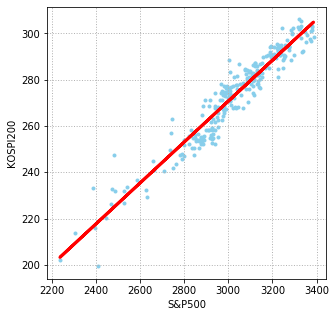

In [56]:
#추세선을 그려보면
plt.figure(figsize=(5,5))
plt.scatter(independent_var, dependent_var, marker='.', color = 'skyblue')
plt.plot(independent_var, regr.predict(independent_var), color ='r', linewidth =3)
plt.grid(True, color = '0.7', linestyle=':', linewidth=1)
plt.xlabel('S&P500')
plt.ylabel('KOSPI200')

In [7]:
# K10 지수 산출
# 네이버에서 한국 10대 기업 데이터 수집하기 
# http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=005930 에서 상장주식수(발행주식수)와 유동비율 추출

import bs4
from urllib.request import urlopen

url_float = 'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=005930'
# Floating ratio from Naver
source = urlopen(url_float).read()
soup = bs4.BeautifulSoup(source, 'lxml')

In [8]:
# 네이버 페이지에서 X-path를 이용해서 원하는 정보를 뽑아야 하는데 마우스 우클릭을 못하게 막아놨음 이 경우에는
# 빈 공간에 마우스 우클릭(또는 Ctrl + Shift + I) 후 Ctrl + F 검색으로 찾고자 하는 정보 입력 + Enter
# 위에거 안되면 코드 직접 열어서 비교해보면서 직접찾아야될 듯
# X-path 주소 : //*[@id="cTB11"]/tbody/tr[7]/td
soup.find(id='cTB11').find_all('tr')[6].td.text #tr[7] 처럼 리스트로 들어있으면 find_all로, td처럼 하나만 있으면 find로 잡기


'\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t5,969,782,550주 / 74.55%\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t'

In [9]:
# \r, \n 등 문자열을 없애려면
tmp = soup.find(id = 'cTB11').find_all('tr')[6].td.text
tmp = tmp.replace('\r', '')
tmp = tmp.replace('\n', '')
tmp = tmp.replace('\t', '')
tmp

'5,969,782,550주 / 74.55%'

In [10]:
#데이터를 다시 상장주식수와 비율로 분리하기 위해서는 re라이브러리 이용
import re
tmp = re.split('/', tmp)
tmp

['5,969,782,550주 ', ' 74.55%']

In [11]:
#발행주식 수에서 정수값만 도출
outstanding = tmp[0].replace(',', '')
outstanding = outstanding.replace('주', '')
outstanding = outstanding.replace(' ','')
outstanding

'5969782550'

In [12]:
#유동비율에서 실수값만 도출
floating = tmp[1].replace(' ', '')
floating = floating.replace('%', '')
floating

'74.55'

In [13]:
# 지금까지 내용을 바탕으로 상장주식 수와 유동비율을 구하는 함수를 만들면
def stock_info(stock_cd):
    url_float = 'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=' + stock_cd
    source = urlopen(url_float).read()
    soup = bs4.BeautifulSoup(source, 'lxml')
    
    tmp = soup.find(id='cTB11').find_all('tr')[6].td.text
    tmp = tmp.replace('\r', '')
    tmp = tmp.replace('\n', '')
    tmp = tmp.replace('\t', '')
    tmp = re.split('/', tmp)
    
    outstanding = tmp[0].replace(',', '')
    outstanding = outstanding.replace('주', '')
    outstanding = outstanding.replace(' ','')
    outstanding = int(outstanding)
    
    floating = tmp[1].replace(' ', '')
    floating = floating.replace('%', '')
    floating = float(floating)
    
    name = soup.find(id = 'pArea').find('div').find('div').find('tr').find('td').find('span').text
    
    k10_outstanding[stock_cd] = outstanding
    k10_floating[stock_cd] = floating
    k10_name[stock_cd] = name
                

In [14]:
'''
한국거래서 시가총액 상위 10종목(2020년 8월 기준)
005930 삼성전자
000660 SK하이닉스
035420 NAVER
051910 LG화학
207940 삼성바이오로직스
068270 셀트리온
005380 현대차
035720 카카오
006400 삼성SDI
051900 LG생활건강
'''
k10_component = ['005930', '000660', '035420', '051910', '207940', '068270', '005380', '035720', '006400','051900']
k10_outstanding = dict()
k10_floating = dict()
k10_name = dict()
for stock_cd in k10_component:
    stock_info(stock_cd)

In [15]:
k10_outstanding

{'005930': 5969782550,
 '000660': 728002365,
 '035420': 164263395,
 '051910': 70592343,
 '207940': 66165000,
 '068270': 134993738,
 '005380': 213668187,
 '035720': 88013995,
 '006400': 68764530,
 '051900': 15618197}

In [87]:
k10_floating

{'005930': 74.62,
 '000660': 73.39,
 '068270': 75.67,
 '005380': 64.41,
 '207940': 24.75,
 '051910': 64.29,
 '005490': 68.55,
 '035420': 75.66,
 '017670': 54.66,
 '015760': 44.68}

In [88]:
k10_name

{'005930': '삼성전자',
 '000660': 'SK하이닉스',
 '068270': '셀트리온',
 '005380': '현대차',
 '207940': '삼성바이오로직스',
 '051910': 'LG화학',
 '005490': 'POSCO',
 '035420': 'NAVER',
 '017670': 'SK텔레콤',
 '015760': '한국전력'}

In [93]:
#과거 주가 구하기
#삼성전자 과거주가 URL : http://finance.naver.com/item/sise_day.nhn?code=005930
# 보면 날짜 데이터는 <td align = "center"><span class = 'tah p10 gray03'></span></td> 태그에 쌓여 있음
# td에 특별한 class가 붙어있지 않으므로 <span> 태그의 class를 이용해 추출하면
stock_cd = '005930'
page_n=1
url_samsung= 'http://finance.naver.com/item/sise_day.nhn?code=' + stock_cd + '&page=' + str(page_n)
source = urlopen(url_samsung).read()
source = bs4.BeautifulSoup(source, 'lxml')
dates = source.find_all('span', class_ = 'tah p10 gray03')
# 종가 부분의 소스 코드를 보면 <td class = "num"></td>
prices = source.find_all('td', class_='num')


In [114]:
import datetime as dt
import pandas as pd

def date_format_html(d):
    d = str(d).replace('-', '.') # 날짜가 -로 구분되어있을 경우 .로 바꿈
    yyyy=int(d.split('.')[0])
    mm=int(d.split('.')[1])
    dd=int(d.split('.')[2])
    
    this_date = dt.date(yyyy,mm,dd)
    return this_date

def historical_stock_naver_date(stock_cd, start_date='', end_date = '', page_n=1, last_page=0):
    if start_date: #start_date가 있으면
        start_date=date_format_html(start_date)
    else: #없으면
        start_date = dt.date.today() #오늘날짜 지정
    if end_date : #end_date가 있으면
        end_date=date_format_html(end_date)
    else:
            end_date=dt.date.today()
    
    naver_stock = 'http://finance.naver.com/item/sise_day.nhn?code=' + stock_cd + '&page=' + str(page_n)
    
    source = urlopen(naver_stock).read()
    source = bs4.BeautifulSoup(source, 'lxml')
    
    dates = source.find_all('span', class_ = 'tah p10 gray03') #날짜수집
    prices = source.find_all('td', class_='num') #종가수집
    
    for n in range(len(dates)):
        
        if len(dates) >0 :
            this_date = dates[n].text
            this_date = date_format_html(this_date)
        
        if this_date <= end_date and this_date >= start_date:
            this_close = prices[n*6].text
            this_close = this_close.replace(',', '')
            this_close = float(this_close)
            
            #딕셔너리에 저장
            historical_prices[this_date] = this_close
        
        elif this_date < start_date :
            return historical_prices
    
    #페이지 네비게이션
    if last_page ==0:
        last_page = source.find_all('table')[1].find('td',class_='pgRR').find('a')['href']
        #마지막페이지 주소 추출
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page=int(last_page)
    
    #다음페이지 호출
    if page_n < last_page:
        page_n = page_n +1
        historical_stock_naver_date(stock_cd, start_date, end_date, page_n, last_page)
    
    return historical_prices


In [115]:
k10_historical_prices = dict()

for stock_cd in k10_component:
    historical_prices = dict()
    start_date = '2017-1-1'
    end_date = '2017-12-31'
    historical_stock_naver_date(stock_cd, start_date, end_date)
    
    k10_historical_prices[stock_cd] = historical_prices


In [116]:
#데이터프레임변환
k10_historical_price = pd.DataFrame(k10_historical_prices)
k10_historical_price.sort_index(axis=1, inplace=True) #axis =1 은 내림차순 (없으면 오름차순), inplace=True는 그래프를 보여주지 말라는 뜻

In [117]:
#보간작업
k10_historical_price = k10_historical_price.fillna(method='ffill')
if k10_historical_price.isnull().values.any():
    k10_historical_price = k10_historical_price.fillna(method='bfill')
k10_historical_price.head(5)

,000660,005380,005490,005930,015760,017670,035420,051910,068270,207940
2017-12-28,76500.0,156000.0,332500.0,2548000.0,38150.0,267000.0,870000.0,405000.0,221100.0,371000.0
2017-12-27,75100.0,156500.0,334500.0,2468000.0,38400.0,267500.0,877000.0,394500.0,220000.0,366000.0
2017-12-26,74000.0,154000.0,339500.0,2410000.0,39100.0,278000.0,874000.0,392000.0,195000.0,344500.0
2017-12-22,76700.0,153000.0,337000.0,2485000.0,38750.0,274000.0,862000.0,393500.0,201900.0,347000.0
2017-12-21,77000.0,150000.0,337000.0,2457000.0,38700.0,272000.0,842000.0,391000.0,197300.0,349000.0


In [118]:
#삼성전자의 경우 2018년 5월 4일부로 1/50 액면분할 -> 주식수는 현재 50배 되었지만 과거 주가는 그대로 -> 수정주가를 구해야 함
k10_historical_price['005930'] = k10_historical_price['005930'] / 50 # 액면분할에 따른 수정주가 계산
k10_historical_price.head()

,000660,005380,005490,005930,015760,017670,035420,051910,068270,207940
2017-12-28,76500.0,156000.0,332500.0,50960.0,38150.0,267000.0,870000.0,405000.0,221100.0,371000.0
2017-12-27,75100.0,156500.0,334500.0,49360.0,38400.0,267500.0,877000.0,394500.0,220000.0,366000.0
2017-12-26,74000.0,154000.0,339500.0,48200.0,39100.0,278000.0,874000.0,392000.0,195000.0,344500.0
2017-12-22,76700.0,153000.0,337000.0,49700.0,38750.0,274000.0,862000.0,393500.0,201900.0,347000.0
2017-12-21,77000.0,150000.0,337000.0,49140.0,38700.0,272000.0,842000.0,391000.0,197300.0,349000.0


In [119]:
# 지수 = 비교시점 시가총액 * 100 /기준시점 시가 총액 
# 각 주식 별 유동주식을 구하면
tmp = {
    'Outstanding' : k10_outstanding,
    'Floating' : k10_floating,
    'Price' : k10_historical_price.iloc[0],
    'Name' : k10_name
}
k10_info = pd.DataFrame(tmp)

In [121]:
#시가 총액은 Market Cap 칼럼에, 유동시가총액은 f Market Cap 칼럼에 저장
k10_info['f Market Cap'] = k10_info['Outstanding'] * k10_info['Floating'] * k10_info['Price'] *0.01
k10_info['Market Cap'] = k10_info['Outstanding'] * k10_info['Price'] * 0.01
k10_info

,Outstanding,Floating,Price,Name,f Market Cap,Market Cap
000660,728002365,73.39,76500.0,SK하이닉스,4.087249e+13,5.569218e+11
005380,213668187,64.41,156000.0,현대차,2.146929e+13,3.333224e+11
005490,87186835,68.55,332500.0,POSCO,1.987239e+13,2.898962e+11
005930,5969782550,74.62,50960.0,삼성전자,2.270091e+14,3.042201e+12
015760,641964077,44.68,38150.0,한국전력,1.094255e+13,2.449093e+11
017670,80745711,54.66,267000.0,SK텔레콤,1.178421e+13,2.155910e+11
035420,164263395,75.66,870000.0,NAVER,1.081251e+14,1.429092e+12
051910,70592343,64.29,405000.0,LG화학,1.838045e+13,2.858990e+11
068270,134939385,75.67,221100.0,셀트리온,2.257622e+13,2.983510e+11
207940,66165000,24.75,371000.0,삼성바이오로직스,6.075436e+12,2.454722e+11


In [122]:
#일자별 시가총액을 구하면
k10_historical_mc = k10_historical_price *k10_info['Outstanding'] * k10_info['Floating'] * 0.01
k10_historical_mc.head(3)

,000660,005380,005490,005930,015760,017670,035420,051910,068270,207940
2017-12-28,4.087249e+13,2.146929e+13,1.987239e+13,2.270091e+14,1.094255e+13,1.178421e+13,1.081251e+14,1.838045e+13,2.257622e+13,6.075436e+12
2017-12-27,4.012450e+13,2.153811e+13,1.999192e+13,2.198816e+14,1.101425e+13,1.180627e+13,1.089950e+14,1.790392e+13,2.246390e+13,5.993557e+12
2017-12-26,3.953679e+13,2.119405e+13,2.029075e+13,2.147142e+14,1.121504e+13,1.226970e+13,1.086222e+14,1.779046e+13,1.991118e+13,5.641476e+12


In [123]:
k10_historical_mc.sum(axis=1) #일자별 시가총액 합, sum(axis=1)는 행의 합, sum()는 열의 합

2017-12-28    4.871071e+14
2017-12-27    4.797131e+14
2017-12-26    4.711858e+14
2017-12-22    4.780686e+14
2017-12-21    4.721827e+14
                  ...     
2017-01-06    3.699913e+14
2017-01-05    3.660550e+14
2017-01-04    3.709805e+14
2017-01-03    3.672853e+14
2017-01-02    3.657001e+14
Length: 243, dtype: float64

In [149]:
# K10 값을 따로 저장
k10 = pd.DataFrame()
k10['K10 Market Cap'] = k10_historical_mc.sum(axis=1)
k10.sort_index(inplace=True) #inplace = True는 변경값을 저장하라는 의미도 있음! k10 = k10.sort_index() 와 같음

In [150]:
#지수화
k10['K10'] = k10['K10 Market Cap'] / k10['K10 Market Cap'][0] *100
k10.head(3)

,K10 Market Cap,K10
2017-01-02,3.657001e+14,100.000000
2017-01-03,3.672853e+14,100.433484
2017-01-04,3.709805e+14,101.443915


In [151]:
#지수 그래프 그리기
import matplotlib.pyplot as plt
%matplotlib inline

No handles with labels found to put in legend.


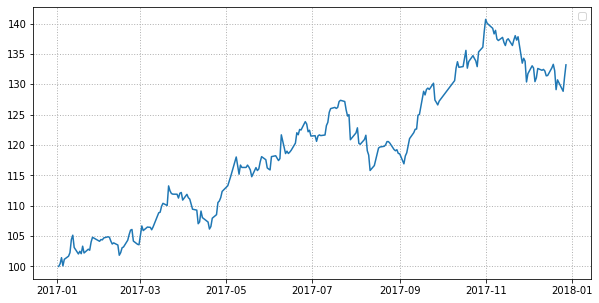

In [152]:
plt.figure(figsize=(10,5))
plt.plot(k10['K10'])
plt.legend(loc=0)
plt.grid(True, color='0.7', linestyle=':', linewidth=1)

In [153]:
#KOSPI200과 비교
from urllib.request import urlopen
import bs4
import datetime as dt

def date_format_html(d):
    d = str(d).replace('-', '.') # 날짜가 -로 구분되어있을 경우 .로 바꿈
    yyyy=int(d.split('.')[0])
    mm=int(d.split('.')[1])
    dd=int(d.split('.')[2])
    
    this_date = dt.date(yyyy,mm,dd)
    return this_date

def historical_index_naver_date(index_cd, start_date='', end_date='', page_n=1, last_page=0):
    index_cd = index_cd
    page_n = page_n
    
    
    if start_date: #start_date가 있으면
        start_date=date_format_html(start_date)
    else: #없으면
        start_date = dt.date.today() #오늘날짜 지정
    if end_date : #end_date가 있으면
        end_date=date_format_html(end_date)
    else:
            end_date=dt.date.today()
    
    naver_index = 'https://finance.naver.com/sise/sise_index_day.nhn?code=' + index_cd + '&page=' + str(page_n) #일별시세-프레임소스보기
    source = urlopen(naver_index).read()
    source = bs4.BeautifulSoup(source, 'lxml') 
    
    dates=source.find_all('td',class_='date') #<td class ="date">태그에서 날짜수집
    prices=source.find_all('td', class_='number_1') #<td class = "number_1">태그에서 지수수집
    
    for n in range(len(dates)): #dates개수만큼 반복
        if dates[n].text.split('.')[0].isdigit():
            #날짜처리
            this_date = dates[n].text
            this_date = date_format_html(this_date)
            
            if this_date <= end_date and this_date >= start_date:
                #종가처리
                this_close=prices[n*4].text
                this_close=this_close.replace(',', '') 
                this_close=float(this_close)
                this_close
    
                #딕셔너리에 저장
                historical_prices_date[this_date] = this_close
            
            elif this_date < start_date:
                return historical_prices_date
    
    #페이지 네비게이션
    if last_page ==0:
        last_page = source.find('td',class_='pgRR').find('a')['href']
        #마지막페이지 주소 추출
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page=int(last_page)
    
    #다음페이지 호출
    if page_n < last_page:
        page_n = page_n +1
        historical_index_naver_date(index_cd, start_date, end_date, page_n, last_page)
    
    return historical_prices_date

historical_prices_date=dict()
kospi200=historical_index_naver_date('KPI200', '2017.1.1', '2017.12.31')
kospi200


{datetime.date(2017, 12, 28): 324.74,
 datetime.date(2017, 12, 27): 320.25,
 datetime.date(2017, 12, 26): 318.89,
 datetime.date(2017, 12, 22): 321.21,
 datetime.date(2017, 12, 21): 319.72,
 datetime.date(2017, 12, 20): 325.79,
 datetime.date(2017, 12, 19): 326.76,
 datetime.date(2017, 12, 18): 326.6,
 datetime.date(2017, 12, 15): 326.23,
 datetime.date(2017, 12, 14): 324.74,
 datetime.date(2017, 12, 13): 326.18,
 datetime.date(2017, 12, 12): 324.07,
 datetime.date(2017, 12, 11): 325.09,
 datetime.date(2017, 12, 8): 324.68,
 datetime.date(2017, 12, 7): 323.59,
 datetime.date(2017, 12, 6): 324.52,
 datetime.date(2017, 12, 5): 329.61,
 datetime.date(2017, 12, 4): 328.77,
 datetime.date(2017, 12, 1): 324.78,
 datetime.date(2017, 11, 30): 325.25,
 datetime.date(2017, 11, 29): 330.68,
 datetime.date(2017, 11, 28): 330.99,
 datetime.date(2017, 11, 27): 329.53,
 datetime.date(2017, 11, 24): 335.44,
 datetime.date(2017, 11, 23): 334.51,
 datetime.date(2017, 11, 22): 335.49,
 datetime.date(2017

In [154]:
k200 = pd.DataFrame({'K200':kospi200}) #그래프를 그리기 위해 kospi200 딕셔너리를 k200 데이터프레임으로 변환, DataFrame은 딕셔너리 안에 리스트여야 가능하므로 {'K200' : kospi200} 이라는 딕셔너리를 만들어준것
k200.head(3)

,K200
2017-01-02,260.36
2017-01-03,262.97
2017-01-04,263.12


No handles with labels found to put in legend.


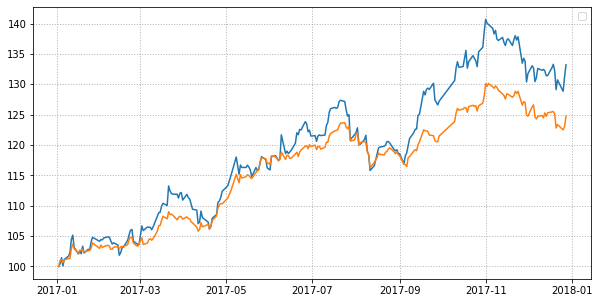

In [155]:
plt.figure(figsize=(10,5))
plt.plot(k10['K10']/k10['K10'][0] * 100)
plt.plot(k200['K200'] / k200['K200'][0] *100)
plt.legend(loc=0)
plt.grid(True, color='0.7', linestyle = ':', linewidth=1)
#결과를 보면 상위 10개 종목이 상위 200개 종목보다 더 많이 올랐다는 것을 알 수 있음